<a href="https://colab.research.google.com/github/Ricardojnf33/Time_series/blob/main/Atividade_3_series_temporais_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Séries Temporais (Cesar School) - Professor : Domingo Sávio de Oliveira
# Alunos: Ricardo Fernandes / Ricardo Cesar / Victor Macaubas / Lucas Dias
Dataset - Carregamento do Dataset - Mapa de Estações - Aeroporto de São Paulo
https://mapas.inmet.gov.br/

# Instalação das bibliotecas

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 10.8 MB/s 
     |████████████████████████████████| 9.8 MB 39.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
pip install tqdm

# Importação das bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import pmdarima as pm
from pmdarima.arima import KPSSTest
from pmdarima.arima import auto_arima
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.8.5

from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVR

from sklearn.base import clone
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import datetime
from tqdm import tqdm
import requests 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Using pmdarima 1.8.5


# Carregamento do Dataset - Mapa de Estações - Aeroporto de São Paulo
https://mapas.inmet.gov.br/

In [4]:

# https://mapas.inmet.gov.br/

start = '2015-01-01'
end = '2022-01-01'
codigo = '83780'
df =  requests.get(f'https://apitempo.inmet.gov.br/estacao/{start}/{end}/{codigo}').json()
df = pd.DataFrame(df)

In [5]:
df.head()

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_HORA,TEMP_HORA,INSO_HORA,NEBU_HORA,TEMP_MED,CHUVA,VENT_VEL,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,PRESS_EST,VENT_DIR,CD_ESTACAO,VL_LONGITUDE,HR_MEDICAO
0,56.5,2015-01-01,SAO PAULO- AEROPORTO,60,25.3,None,7.5,26.4,None,3.1,-23.62,None,32.3,SP,924.1,330,83780,-46.65,0000
1,None,2015-01-01,SAO PAULO- AEROPORTO,69,24,None,None,None,None,None,-23.62,None,None,SP,922.7,None,83780,-46.65,0300
2,None,2015-01-01,SAO PAULO- AEROPORTO,71,23.6,None,6.3,None,None,2.6,-23.62,None,None,SP,923.3,310,83780,-46.65,0600
3,None,2015-01-01,SAO PAULO- AEROPORTO,57,27.6,None,None,None,None,None,-23.62,None,None,SP,924.3,None,83780,-46.65,0900
4,None,2015-01-01,SAO PAULO- AEROPORTO,44,30.9,None,0,None,0,6.2,-23.62,23.6,None,SP,923.5,320,83780,-46.65,1200


In [6]:
df.tail()

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_HORA,TEMP_HORA,INSO_HORA,NEBU_HORA,TEMP_MED,CHUVA,VENT_VEL,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,PRESS_EST,VENT_DIR,CD_ESTACAO,VL_LONGITUDE,HR_MEDICAO
20459,None,2022-01-01,SAO PAULO- AEROPORTO,None,None,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,0900
20460,None,2022-01-01,SAO PAULO- AEROPORTO,79,21.6,None,10,None,31,2.6,-23.62,18.1,None,SP,921.1,320,83780,-46.65,1200
20461,None,2022-01-01,SAO PAULO- AEROPORTO,None,None,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,1500
20462,None,2022-01-01,SAO PAULO- AEROPORTO,72,23.3,None,10,None,None,3.6,-23.62,None,None,SP,919.8,50,83780,-46.65,1800
20463,None,2022-01-01,SAO PAULO- AEROPORTO,None,None,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,2100


In [7]:
#configurar o plot
plt.rcParams["figure.figsize"] = (15,5)

In [8]:
serie_temp = df['TEMP_HORA'].iloc[0:400]                         
serie_temp = serie_temp.apply(lambda x: 0 if pd.isna(x) else float(x))

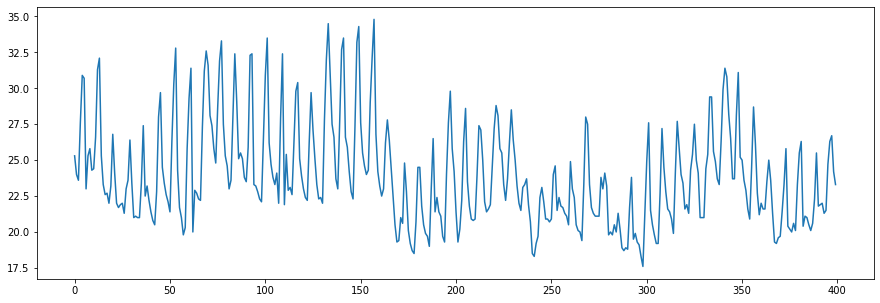

In [9]:
serie_temp.plot()

## Plotando gráfico de auto-correlação e auto-correlação parcial

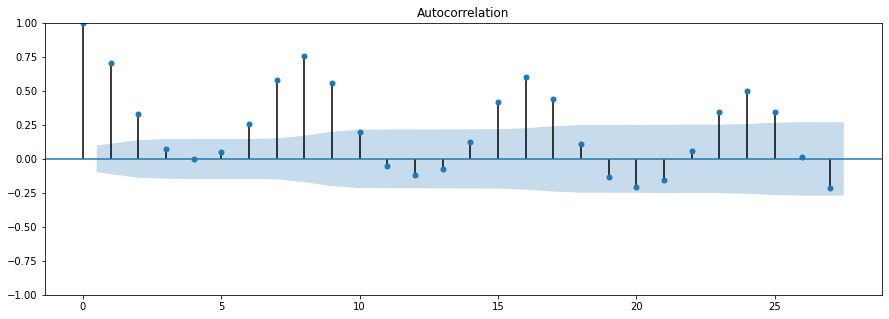

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


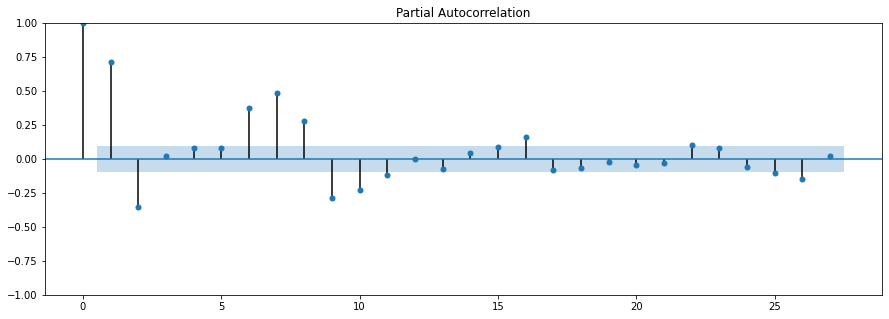

In [10]:
serie = serie_temp
plot_acf(serie)
plt.show()
plot_pacf(serie)
plt.show()

# Primeiro Teste KPSS
(True) - Serie Não Estacionária

In [11]:
kpss = KPSSTest()
kpss.should_diff(serie_temp)

(0.01, True)

# Aplicando diferenciação

## Plot gráfico da primeira diferenciação, com m = 1, auto-correlação e auto-correlação parcial.

In [12]:
def get_diff(dataset, interval=1):
  diff = list()
  for i in range(interval, dataset.shape[0]):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)
TEMP_diff = get_diff(serie_temp, 1)  

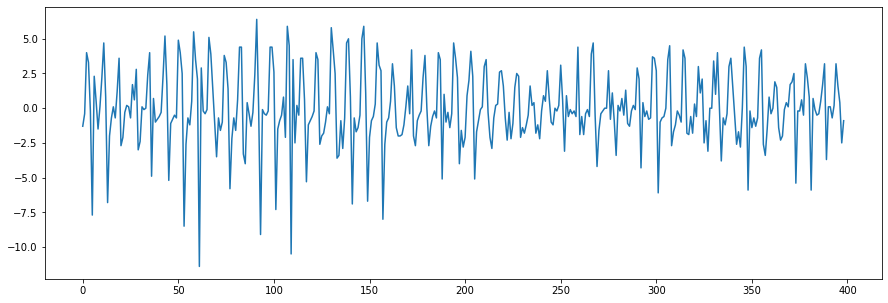

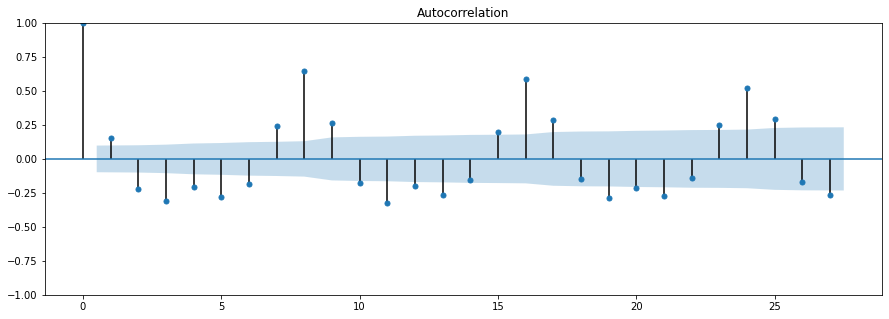

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


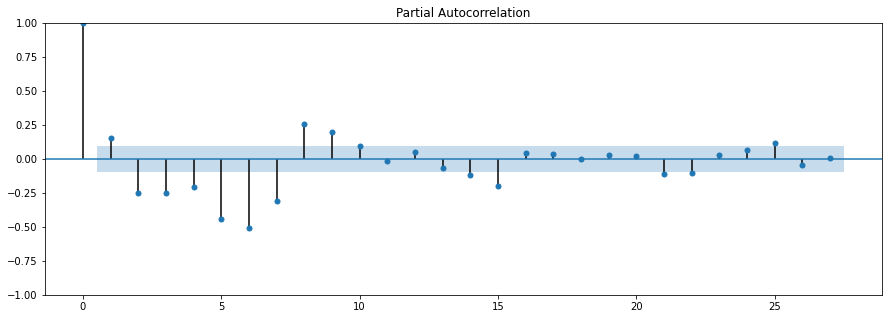

In [13]:
temp_diff = get_diff(serie_temp, 1)  
temp_diff.plot()
plt.show()
serie = temp_diff
plot_acf(serie)
plt.show()
plot_pacf(serie)
plt.show()

## Plot gráfico da segunda diferenciação, com m = 4 e auto-correlação e auto-correlação parcial final

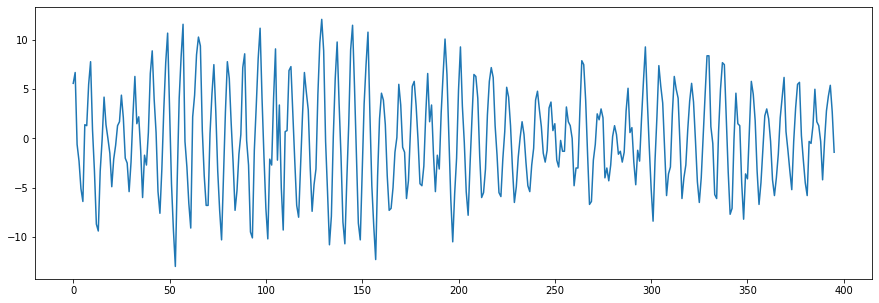

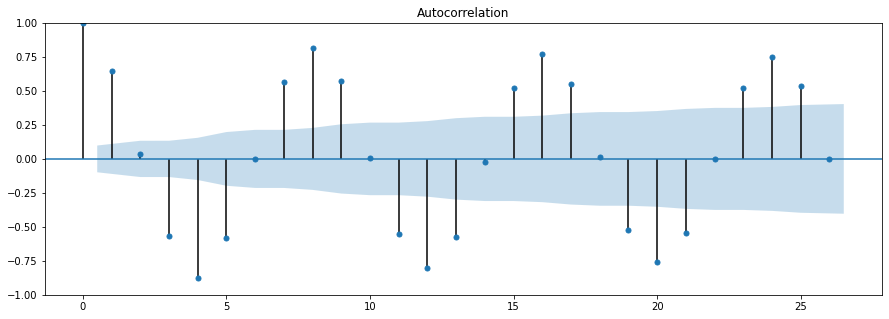

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


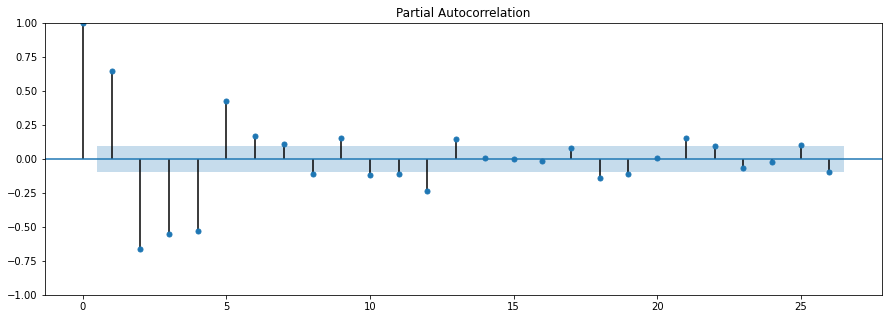

In [14]:
temp_diff_2 = get_diff(serie_temp, 4)  
temp_diff_2.plot()
plt.show()
serie = temp_diff_2
plot_acf(serie)
plt.show()
plot_pacf(serie)
plt.show()

# Segundo Test KPSS 
(False) - Transformação em Serie Estacionária

In [15]:
kpss = KPSSTest()

kpss.should_diff(temp_diff)

(0.1, False)

# Média Móvel ( RETIRAR MEDIA MOVEL )

In [16]:
example = serie_temp
ma_size = 50

for i in range(ma_size, len(example)):
  consider_val = example[i-ma_size:i]
  print(f'valores considerados: {consider_val}, MA {np.mean(consider_val)}')

A saída de streaming foi truncada nas últimas 5000 linhas.
300    24.9
Name: TEMP_HORA, dtype: float64, MA 21.479999999999997
valores considerados: 252    24.6
253    21.5
254    22.4
255    21.8
256    21.7
257    21.3
258    21.1
259    20.5
260    24.9
261    23.0
262    22.4
263    20.5
264    20.1
265    20.0
266    19.4
267    23.3
268    28.0
269    27.5
270    23.3
271    21.7
272    21.3
273    21.1
274    21.1
275    21.1
276    23.8
277    23.0
278    24.1
279    23.2
280    19.8
281    20.0
282    19.8
283    20.5
284    20.0
285    21.3
286    20.2
287    18.9
288    18.7
289    18.9
290    18.8
291    21.7
292    23.8
293    19.5
294    19.9
295    19.3
296    19.1
297    18.3
298    17.6
299    21.3
300    24.9
301    27.6
Name: TEMP_HORA, dtype: float64, MA 21.552
valores considerados: 253    21.5
254    22.4
255    21.8
256    21.7
257    21.3
258    21.1
259    20.5
260    24.9
261    23.0
262    22.4
263    20.5
264    20.1
265    20.0
266    19.4
267    23.3
268    

## MA - 22,5

In [17]:
def show_trend(serie_temp, ma_size): 
  df_serie = pd.DataFrame()
  df_serie['serie'] = serie_temp.values[ma_size:]
  df_serie['MA'] = serie_temp.rolling(ma_size).mean().values[ma_size:]

  df_serie.plot()

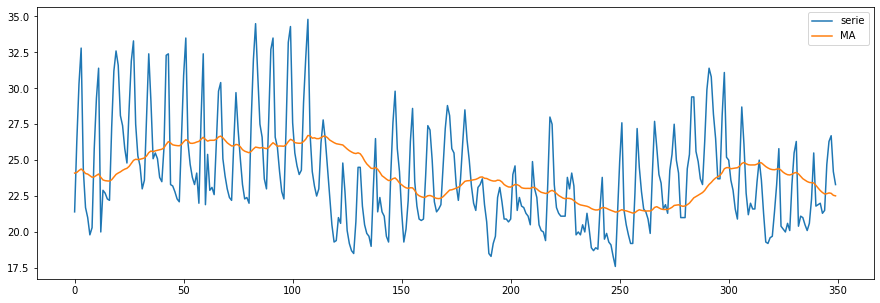

In [18]:
show_trend(serie_temp, ma_size)

In [19]:
serie_temp.describe()

count    400.000000
mean      23.955750
std        3.527126
min       17.600000
25%       21.375000
50%       23.300000
75%       25.900000
max       34.800000
Name: TEMP_HORA, dtype: float64

# Implementação do modelo ARIMA / m=1

In [20]:
model = auto_arima(serie_temp, #X=None,
           start_p=2, d=None, start_q=2,
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1801.642, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1927.689, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1920.353, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1915.289, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1925.690, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1827.909, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1795.618, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1915.756, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1897.304, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1780.808, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1873.030, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1765.759, Time=0.43 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1858.445, Time=0.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1702.649, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept

## Arima com 5 regressões, 1 diferenciação e 1 média móvel

# Implementação do modelo ARIMA / m=4 , na base 'serie_temp'

In [21]:
model = auto_arima(serie_temp, #X=None,
           start_p=2, d=None, start_q=2,
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=4, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1675.067, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1927.689, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1913.315, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1914.907, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1925.690, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=1809.827, Time=0.24 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=1771.270, Time=0.28 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=1614.916, Time=0.43 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=1634.073, Time=0.40 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=1568.364, Time=0.52 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=1664.141, Time=0.39 sec
 ARIMA(1,1,2)(2,0,2)[4] intercept   : AIC=1568.110, Time=0.38 sec
 ARIMA(1,1,2)(1,0,2)[4] intercept   : AIC=1646.932, Time=0.33 sec
 ARIMA(1,1,2)(2,0,1)[4] intercept   : AIC=1611.933, Time=0.32 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept

## Arima com 1 regressões, 1 diferenciação e 2 médias móveis ; Ordem sazonal (2,0,2,4)

# Aplicação do Predict nos proximos 10 dias

In [22]:
model.predict(10)

array([22.37686523, 21.97171932, 21.90333099, 24.32872404, 26.37129506,
       26.81889517, 24.2209878 , 23.16635323, 22.415737  , 22.09376774])

In [23]:
serie_temp.shape[0]

400

## Separação de 10% para test e 90% train

In [24]:
test_size = int(serie_temp.shape[0] * 0.1)

In [25]:
train = serie_temp.iloc[0:-test_size] # iloc do dado mais antigo, até o início de test_size = train
test = serie_temp.iloc[-test_size:] # iloc do Início de test_size até o final = test 

## Modelo Auto_arima setado em train / m = 4, na base 'train'

In [26]:
model = auto_arima(train, #X=None,
           start_p=2, d=None, start_q=2,
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=4, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1525.137, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1752.411, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1737.721, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1739.404, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1750.417, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=1639.618, Time=0.24 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=1602.352, Time=0.27 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=1475.409, Time=0.43 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=1492.621, Time=0.36 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=1432.388, Time=0.40 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=1516.751, Time=0.37 sec
 ARIMA(1,1,2)(2,0,2)[4] intercept   : AIC=1436.584, Time=0.32 sec
 ARIMA(2,1,1)(2,0,2)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,2)(2,0,2)[4] intercept   : AIC=1427.041, Time=0.45 sec
 ARIMA(3,1,2)(1,0,2)[4] intercept   : 

### Arima com 3 regressões, 1 diferenciação e 1 médias móveis ; Ordem sazonal (2,0,2,4)

## Test tqdm

### Perseguir test, aplicar o predict e atualizar o modelo com o último valor predito 

In [27]:
test_prevs_h1 = []

for t in tqdm(test):
    test_prevs_h1.append(model.predict(1)[0])
    model.update(t)

100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


### Plot entre serie real e previsão 1 dia após última data

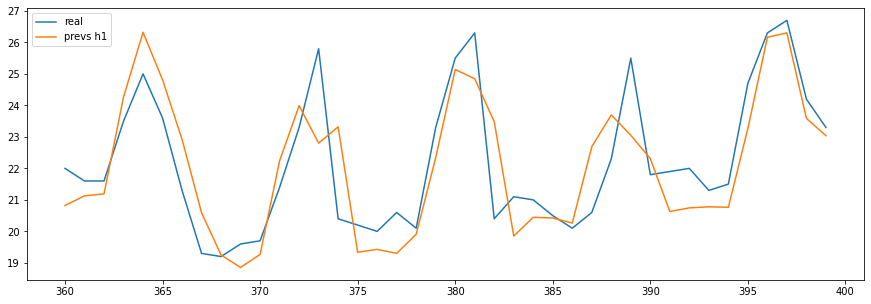

In [28]:
pd.DataFrame({'real': test, 'prevs h1': test_prevs_h1}).plot()

# Plot entre serie real e previsão 1 dia após última data

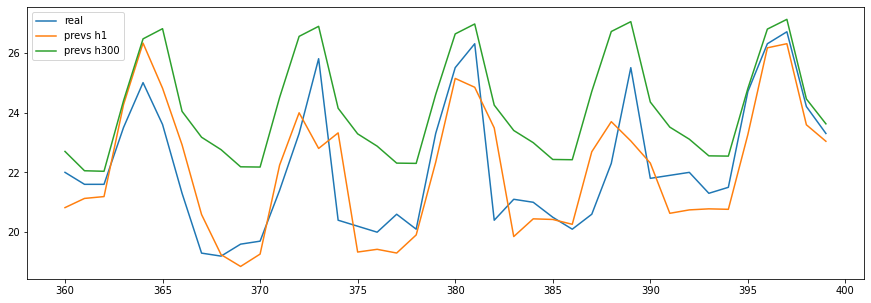

In [29]:
test_prevs_h300 = model.predict(test_size)

pd.DataFrame({'real': test, 'prevs h1': test_prevs_h1, 
              'prevs h300': test_prevs_h300}).plot()

# Métricas

### Teste MSE 

In [30]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

mean_square_error(test, test_prevs_h1)

1.6487914747817496

In [31]:
mean_square_error(test, test_prevs_h300)

5.296292415193562

# Teste MAPE

In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test, test_prevs_h1)

4.599507856745863

# Teste ARV

In [33]:
def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf

average_relative_variance(test, test_prevs_h1)

0.3680639917852594

## teste U_theil ( Acima 1, pior que random walker )

In [34]:
def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf

In [35]:
u_theil(test, test_prevs_h1)

0.552684422075626

# Teste POCID

In [36]:
def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


prediction_of_change_in_direction(test, test_prevs_h1)

60.0

# Implementação de modelo de Machine Learning

In [37]:
df

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_HORA,TEMP_HORA,INSO_HORA,NEBU_HORA,TEMP_MED,CHUVA,VENT_VEL,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,PRESS_EST,VENT_DIR,CD_ESTACAO,VL_LONGITUDE,HR_MEDICAO
0,56.5,2015-01-01,SAO PAULO- AEROPORTO,60,25.3,None,7.5,26.4,None,3.1,-23.62,None,32.3,SP,924.1,330,83780,-46.65,0000
1,None,2015-01-01,SAO PAULO- AEROPORTO,69,24,None,None,None,None,None,-23.62,None,None,SP,922.7,None,83780,-46.65,0300
2,None,2015-01-01,SAO PAULO- AEROPORTO,71,23.6,None,6.3,None,None,2.6,-23.62,None,None,SP,923.3,310,83780,-46.65,0600
3,None,2015-01-01,SAO PAULO- AEROPORTO,57,27.6,None,None,None,None,None,-23.62,None,None,SP,924.3,None,83780,-46.65,0900
4,None,2015-01-01,SAO PAULO- AEROPORTO,44,30.9,None,0,None,0,6.2,-23.62,23.6,None,SP,923.5,320,83780,-46.65,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20459,None,2022-01-01,SAO PAULO- AEROPORTO,None,None,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,0900
20460,None,2022-01-01,SAO PAULO- AEROPORTO,79,21.6,None,10,None,31,2.6,-23.62,18.1,None,SP,921.1,320,83780,-46.65,1200
20461,None,2022-01-01,SAO PAULO- AEROPORTO,None,None,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,1500
20462,None,2022-01-01,SAO PAULO- AEROPORTO,72,23.3,None,10,None,None,3.6,-23.62,None,None,SP,919.8,50,83780,-46.65,1800


In [38]:
df.reset_index(inplace=True)

In [39]:
df['DT_MEDICAO'] = pd.to_datetime(df['DT_MEDICAO'])

In [40]:
df.set_index('DT_MEDICAO', inplace=True)

In [41]:
df = df[['TEMP_HORA']]

In [42]:
df.index.min()

Timestamp('2015-01-01 00:00:00')

In [43]:
dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
dates = pd.DataFrame({'Date': dates}).set_index('Date')

In [44]:
df = dates.join(df, how='left')

In [45]:
df

,TEMP_HORA
2015-01-01,25.3
2015-01-01,24
2015-01-01,23.6
2015-01-01,27.6
2015-01-01,30.9
...,...
2021-12-31,None
2021-12-31,21.8
2021-12-31,None
2021-12-31,19.8


In [46]:
pd.isna(df['TEMP_HORA']).value_counts(normalize=True)

False    0.729543
True     0.270457
Name: TEMP_HORA, dtype: float64

In [47]:
df1 = pd.DataFrame({'date':pd.date_range(start=df.index.min(), end=df.index.max(), freq='M')})

In [48]:
df1['date'].shift(0)

0    2015-01-31
1    2015-02-28
2    2015-03-31
3    2015-04-30
4    2015-05-31
        ...    
79   2021-08-31
80   2021-09-30
81   2021-10-31
82   2021-11-30
83   2021-12-31
Name: date, Length: 84, dtype: datetime64[ns]

In [49]:
def creating_windowing(df1, lag_size):
  all_series = []
  for i in reversed(range(0, lag_size+1)):
    serie = df.shift(i)
    if i==0:
      serie.columns= ['actual']
    else:
      serie.columns= [f'lag_{i}']

    all_series.append(serie)

  df_lagged = pd.concat(all_series, axis=1)
  df_lagged.dropna(inplace=True)

  return df_lagged

In [50]:
creating_windowing(df1, 3)

,lag_3,lag_2,lag_1,actual
2015-01-01,25.3,24,23.6,27.6
2015-01-01,24,23.6,27.6,30.9
2015-01-01,23.6,27.6,30.9,30.7
2015-01-01,27.6,30.9,30.7,23
2015-01-01,30.9,30.7,23,25.3
...,...,...,...,...
2019-12-31,28,23.4,21,21
2019-12-31,20.5,25.4,30.5,27.7
2019-12-31,25.4,30.5,27.7,24.8
2019-12-31,30.5,27.7,24.8,23.9


In [51]:
lag_size = 3
horizon = 2
df_lagged = creating_windowing(df1, lag_size+horizon-1)

In [52]:
labels_lags = [f'lag_{c}'for c in reversed(range(1, lag_size+1))]
labels_horizons = [f'target_{c}'for c in (range(1, horizon+1))]

In [53]:
df_lagged.columns = labels_lags + labels_horizons

In [54]:
df_lagged.drop(columns=['target_1'])

,lag_3,lag_2,lag_1,target_2
2015-01-01,25.3,24,23.6,30.9
2015-01-01,24,23.6,27.6,30.7
2015-01-01,23.6,27.6,30.9,23
2015-01-01,27.6,30.9,30.7,25.3
2015-01-02,30.9,30.7,23,25.8
...,...,...,...,...
2019-12-30,23.8,29.4,28,21
2019-12-31,29.4,28,23.4,21
2019-12-31,20.5,25.4,30.5,24.8
2019-12-31,25.4,30.5,27.7,23.9


## Setando o modelo de Machine Learning ( MLPRegressor )

In [55]:
df_lagged['lag_1']

2015-01-01    23.6
2015-01-01    27.6
2015-01-01    30.9
2015-01-01    30.7
2015-01-02      23
              ... 
2019-12-30      28
2019-12-31    23.4
2019-12-31    30.5
2019-12-31    27.7
2020-01-01    24.8
Name: lag_1, Length: 4072, dtype: object

In [56]:
df_lagged2 = df_lagged.drop(columns=['target_2', 'target_1'])
X = df_lagged2.to_numpy()
X

array([['25.3', '24', '23.6'],
       ['24', '23.6', '27.6'],
       ['23.6', '27.6', '30.9'],
       ...,
       ['20.5', '25.4', '30.5'],
       ['25.4', '30.5', '27.7'],
       ['30.5', '27.7', '24.8']], dtype=object)

In [57]:
y = df_lagged['target_2']
y

2015-01-01    30.9
2015-01-01    30.7
2015-01-01      23
2015-01-01    25.3
2015-01-02    25.8
              ... 
2019-12-30      21
2019-12-31      21
2019-12-31    24.8
2019-12-31    23.9
2020-01-01    23.9
Name: target_2, Length: 4072, dtype: object

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X , y)

regr = MLPRegressor(max_iter=500).fit(X_train, y_train)

In [59]:
regr.predict(X_test[:10])

array([22.92587196, 13.72841663, 23.36872834, 16.78160247, 21.24950068,
       14.70082971, 23.14699288, 14.94183822, 14.74629752, 25.77075677])

In [84]:
regr.score(X_test, y_test)

0.6276127711566575

# Setando Ensemble ( Random Forest + Gradient boosting )

In [74]:
def create_windowing(df, lag_size):
    final_df = None
    for i in range(0, (lag_size + 1)):
        serie = df.shift(i)
        if (i == 0):
            serie.columns = ['actual']
        else:
            serie.columns = [str('lag' + str(i))]
        final_df = pd.concat([serie, final_df], axis=1)

    return final_df.dropna()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [75]:
codigo = '83780' #Joao pessoa codigo retirado de: https://mapas.inmet.gov.br/
start = '2015-01-01'
end = '2022-01-01'
df =  requests.get(f'https://apitempo.inmet.gov.br/estacao/{start}/{end}/{codigo}').json()
df = pd.DataFrame(df)
df['TEMP_HORA'] = df['TEMP_HORA'].apply(lambda x: 0 if pd.isna(x) else float(x) )

series = df['TEMP_HORA'].iloc[0:400]

In [76]:
df

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_HORA,TEMP_HORA,INSO_HORA,NEBU_HORA,TEMP_MED,CHUVA,VENT_VEL,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,PRESS_EST,VENT_DIR,CD_ESTACAO,VL_LONGITUDE,HR_MEDICAO
0,56.5,2015-01-01,SAO PAULO- AEROPORTO,60,25.3,None,7.5,26.4,None,3.1,-23.62,None,32.3,SP,924.1,330,83780,-46.65,0000
1,None,2015-01-01,SAO PAULO- AEROPORTO,69,24.0,None,None,None,None,None,-23.62,None,None,SP,922.7,None,83780,-46.65,0300
2,None,2015-01-01,SAO PAULO- AEROPORTO,71,23.6,None,6.3,None,None,2.6,-23.62,None,None,SP,923.3,310,83780,-46.65,0600
3,None,2015-01-01,SAO PAULO- AEROPORTO,57,27.6,None,None,None,None,None,-23.62,None,None,SP,924.3,None,83780,-46.65,0900
4,None,2015-01-01,SAO PAULO- AEROPORTO,44,30.9,None,0,None,0,6.2,-23.62,23.6,None,SP,923.5,320,83780,-46.65,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20459,None,2022-01-01,SAO PAULO- AEROPORTO,None,0.0,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,0900
20460,None,2022-01-01,SAO PAULO- AEROPORTO,79,21.6,None,10,None,31,2.6,-23.62,18.1,None,SP,921.1,320,83780,-46.65,1200
20461,None,2022-01-01,SAO PAULO- AEROPORTO,None,0.0,None,None,None,None,None,-23.62,None,None,SP,None,None,83780,-46.65,1500
20462,None,2022-01-01,SAO PAULO- AEROPORTO,72,23.3,None,10,None,None,3.6,-23.62,None,None,SP,919.8,50,83780,-46.65,1800


In [77]:
def holdout(actual_model, insample, val_size):
  
  x_train = insample[0:-val_size].drop(columns=['actual'])
  y_train = insample[0:-val_size]['actual']

  x_val = insample[-val_size:].drop(columns=['actual'])
  y_val = insample[-val_size:]['actual']

  actual_model.fit(x_train, y_train)

  pred = actual_model.predict(x_val)

  actual_model.fit(insample.drop(columns=['actual']), insample['actual'])
  return actual_model, mean_absolute_percentage_error(y_val, pred)

def get_test_info(actual_model, out_of_sample, min_max_scaler):
  x_test = out_of_sample.drop(columns=['actual'])
  y_test = out_of_sample['actual']

  prevs = actual_model.predict(x_test)
  prevs = min_max_scaler.inverse_transform(prevs.reshape(-1,1)).flatten()
  real = min_max_scaler.inverse_transform(y_test.values.reshape(-1,1)).flatten()

  return {'metric': mean_absolute_percentage_error(real, prevs),
          'real': real,
          'prev': prevs}

def dispacth(forecast, series, list_params, test_size, val_size):
  min_max_scaler = preprocessing.MinMaxScaler()
  min_max_scaler.fit(series.iloc[0:-test_size].values.reshape(-1,1))
  serie_norm = min_max_scaler.transform(series.values.reshape(-1,1))
  serie_norm = serie_norm.flatten()

  val_metric = []
  models = []
  test_info = []

  for params in tqdm(list_params):
    model_params = params.copy()
    del model_params['time_window']

    series_lagged = create_windowing(pd.DataFrame({'actual': serie_norm}), params['time_window'])

    actual_model = clone(forecast).set_params(**model_params)
    insample = series_lagged.iloc[0:-test_size]
    out_of_sample = series_lagged.iloc[-test_size:]

    actual_model, mape = holdout(actual_model, insample, val_size)

    test_info.append(get_test_info(actual_model, out_of_sample, min_max_scaler))
                    
    val_metric.append(mape)
    models.append(actual_model)


  best_val = np.argmin(val_metric)
  test_selected = test_info[best_val]
  print(f'Melhor params : {list_params[best_val]}')
  print(f'Val Metrics  : {val_metric[best_val]}')

  return test_selected

In [78]:
parameters = {'hidden_layer_sizes': [20, 50, 100], 
                'max_iter': [1000],
                'tol': [0.001, 0.0001, 0.00001],
                'time_window': [12, 24, 48]
            }
forecast = MLPRegressor()
test_size = 40
val_size = 40
list_params = list(ParameterGrid(parameters))

mlp_results = dispacth(forecast, series, list_params, test_size, val_size)

100%|██████████| 27/27 [00:09<00:00,  2.70it/s]

Melhor params : {'hidden_layer_sizes': 50, 'max_iter': 1000, 'time_window': 24, 'tol': 1e-05}
Val Metrics  : 15.980769065401008


In [79]:
parameters = {'C':[1, 10, 100 ], 'gamma': [0.1, 0.01, 0.001],
              'kernel':["rbf"],
              'epsilon': [0.1, 0.01, 0.001],
              'time_window': [12, 24, 48]
            }

forecast = SVR()
test_size = 40
val_size = 40
list_params = list(ParameterGrid(parameters))

svr_results = dispacth(forecast, series, list_params, test_size, val_size)

100%|██████████| 81/81 [00:04<00:00, 16.71it/s]

Melhor params : {'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf', 'time_window': 12}
Val Metrics  : 15.821547894367818


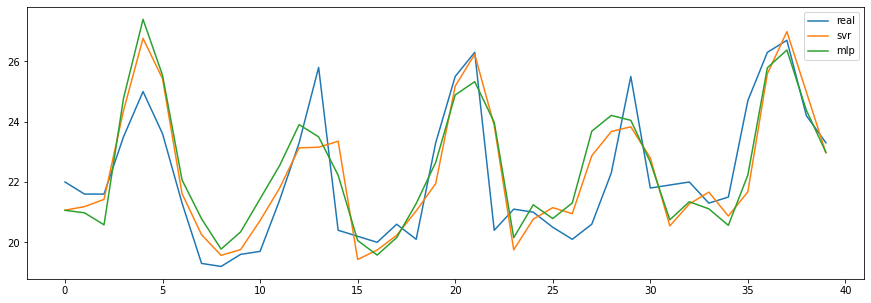

In [80]:
pd.DataFrame({
    'real': svr_results['real'],
    'svr': svr_results['prev'],
    'mlp': mlp_results['prev'],
}).plot()

In [83]:
mlp_results['metric']

5.0019977638292135

In [82]:
svr_results['metric']

4.523895981693685

# Comparação de métricas

### Métricas Modelo Auto-Arima

In [91]:
mean_square_error(test, test_prevs_h1)

1.6487914747817496

In [92]:
mean_square_error(test, test_prevs_h300)

5.296292415193562

In [93]:
mean_absolute_percentage_error(test, test_prevs_h1)

4.599507856745863

In [94]:
average_relative_variance(test, test_prevs_h1)

0.3680639917852594

In [95]:
u_theil(test, test_prevs_h1)

0.552684422075626

In [ ]:
prediction_of_change_in_direction(test, test_prevs_h1)

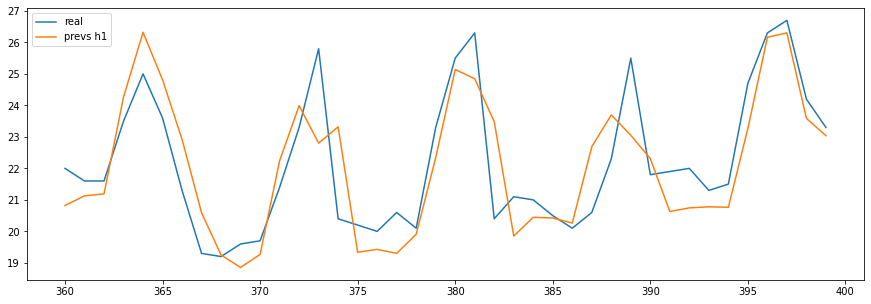

In [88]:
pd.DataFrame({'real': test, 'prevs h1': test_prevs_h1}).plot()

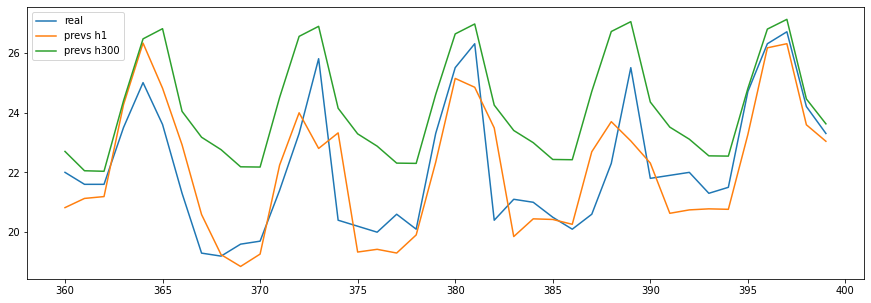

In [90]:
test_prevs_h300 = model.predict(test_size)

pd.DataFrame({'real': test, 'prevs h1': test_prevs_h1, 
              'prevs h300': test_prevs_h300}).plot()

### Score MLPRegressor

In [85]:
regr.score(X_test, y_test)

0.6276127711566575

### Score Esemble ( Random Forest + Gradient Boosting )

In [86]:
mlp_results['metric']

5.0019977638292135

In [87]:
svr_results['metric']

4.523895981693685

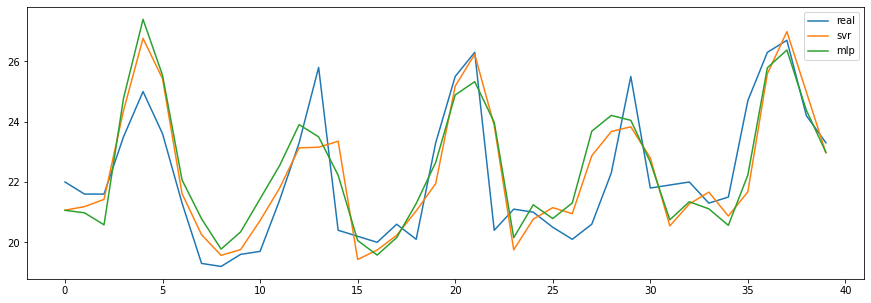

In [89]:
pd.DataFrame({
    'real': svr_results['real'],
    'svr': svr_results['prev'],
    'mlp': mlp_results['prev'],
}).plot()